In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms

# Set device variable

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


# Prepare Dataset objects

In [3]:
data_path = './'

cifar10 = datasets.CIFAR10(
    data_path, train=True, download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4915, 0.4823, 0.4468),
                             (0.2470, 0.2435, 0.2616))
    ]))

cifar10_val = datasets.CIFAR10(
    data_path, train=False, download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4915, 0.4823, 0.4468),
                             (0.2470, 0.2435, 0.2616))
    ]))

n_out = 10

100%|██████████| 170498071/170498071 [00:03<00:00, 44303851.62it/s]


Extracting ./cifar-10-python.tar.gz to ./
Files already downloaded and verified


# Prepare Dataloader objects

The torch.utils.data module has a **DataLoader** class that helps with shuffling and organizing the data in minibatches.

The job of a data loader is to sample minibatches from a dataset, giving us the flexibility to choose from different sampling strategies. A very common strategy is uniform sampling after shuffling the data at each epoch.

At a minimum, the DataLoader constructor takes a Dataset object as input, along with batch_size and a shuffle Boolean that indicates whether the data needs to be shuffled at the beginning of each epoch

The following shows the data loader shuffling the indices it gets from the Dataset.

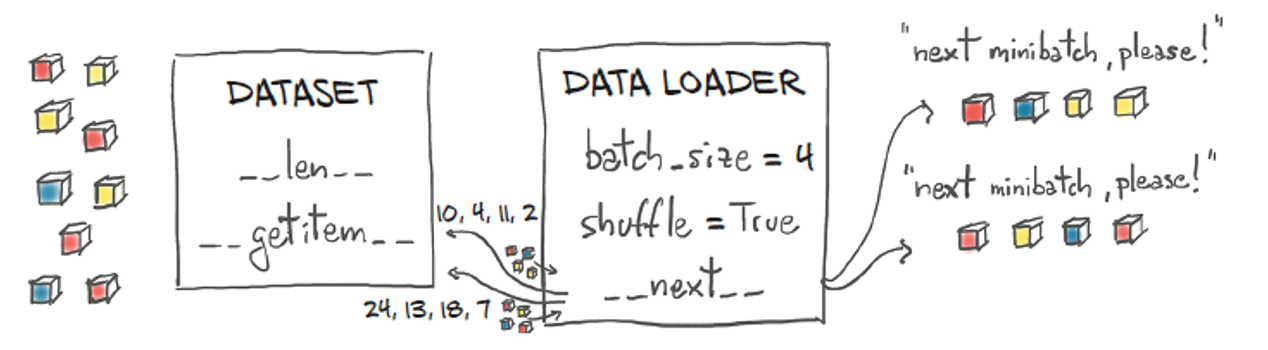

In [4]:
kwargs = {'num_workers': 1, 'pin_memory': True} if torch.cuda.is_available()else {}

train_loader = torch.utils.data.DataLoader(cifar10, batch_size=64, shuffle=True,  **kwargs)

val_loader = torch.utils.data.DataLoader(cifar10_val, batch_size=64,shuffle=False, **kwargs)

# An Example of Image Classification

In [6]:
model = nn.Sequential(
    nn.Linear(3072, 1024),
    nn.Tanh(),
    nn.Linear(1024, 512),
    nn.Tanh(),
    nn.Linear(512, 128),
    nn.Tanh(),
    nn.Linear(128, n_out)
)

model.to(device)  # move model parameters to GPU for computation acceleration

Sequential(
  (0): Linear(in_features=3072, out_features=1024, bias=True)
  (1): Tanh()
  (2): Linear(in_features=1024, out_features=512, bias=True)
  (3): Tanh()
  (4): Linear(in_features=512, out_features=128, bias=True)
  (5): Tanh()
  (6): Linear(in_features=128, out_features=10, bias=True)
)

# Start Training

In [7]:
learning_rate = 1e-2

optimizer = optim.SGD(model.parameters(), lr=learning_rate)

loss_fn = nn.CrossEntropyLoss()

n_epochs = 100

for epoch in range(n_epochs):
    model.train(True)
    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)   # move tensors to GPU for computation acceleration

        # imgs.view(imgs.shape[0], -1): In order to call the model, we need to make the input have the right dimensions.
        # We recall that our model expects 3,072 features in the input, and that nn works with data organized into batches along the zeroth dimension.
        # So we need to turn our 3 × 32 × 32 image into a 1D tensor and then add an extra dimension in the zeroth position.
        outputs = model(imgs.view(imgs.shape[0], -1))
        train_loss = loss_fn(outputs, labels)

        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()

    model.eval()

    correct = 0
    total = 0
    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(device), labels.to(device)   # move tensors to GPU for computation acceleration

            outputs = model(imgs.view(imgs.shape[0], -1))
            val_loss = loss_fn(outputs, labels)

            _, predicted = torch.max(outputs, dim=1)
            total += labels.shape[0]
            correct += int((predicted == labels).sum())
    print("Epoch: %d, train_loss: %f, val_loss: %f, val_accuracy: %f" % (epoch, float(train_loss), float(val_loss), (correct / total)))

Epoch: 0, train_loss: 2.607688, val_loss: 1.636016, val_accuracy: 0.377800
Epoch: 1, train_loss: 1.738945, val_loss: 1.594678, val_accuracy: 0.401200
Epoch: 2, train_loss: 1.647449, val_loss: 1.691647, val_accuracy: 0.409800
Epoch: 3, train_loss: 1.590344, val_loss: 1.629552, val_accuracy: 0.427000
Epoch: 4, train_loss: 2.004777, val_loss: 1.639276, val_accuracy: 0.436000
Epoch: 5, train_loss: 1.220710, val_loss: 1.663335, val_accuracy: 0.439800
Epoch: 6, train_loss: 1.374508, val_loss: 1.547611, val_accuracy: 0.446300
Epoch: 7, train_loss: 1.131901, val_loss: 1.639713, val_accuracy: 0.459800
Epoch: 8, train_loss: 1.550484, val_loss: 1.489345, val_accuracy: 0.464800
Epoch: 9, train_loss: 0.753155, val_loss: 1.490008, val_accuracy: 0.457700
Epoch: 10, train_loss: 0.966685, val_loss: 1.371431, val_accuracy: 0.451800
Epoch: 11, train_loss: 1.029667, val_loss: 1.584204, val_accuracy: 0.440300
Epoch: 12, train_loss: 0.947352, val_loss: 1.409460, val_accuracy: 0.481400


KeyboardInterrupt: ignored

# Some Notes

## Softmax
**Softmax** is a function that takes a vector of values and produces another vector of the same dimension, where the values satisfy the constraints we just listed to represent probabilities

The nn module makes softmax available as a module.

> - Since, as usual, input tensors may have an additional batch 0th dimension, or have dimensions along which they encode probabilities and others in which they don’t, nn.Softmax requires us to specify the dimension along which the softmax function is applied.

In [ ]:
# let's define softmax function
def softmax(x):
    return torch.exp(x) / torch.exp(x).sum()

x = torch.tensor([1.0, 2.0, 3.0])

print('softmax(x)-->',softmax(x))
print('softmax(x).sum()--> ',softmax(x).sum())

In [ ]:
softmax = nn.Softmax(dim=1)

x = torch.tensor([[1.0, 2.0, 3.0], [1.0, 2.0, 3.0]])

print('softmax(x)-->',softmax(x))

## Loss Function for Multi-class Classification

In classification, we want to maximize the probability associated with the correct class.

So a loss function to use, should be
> - very high when the probability associated with the correct class is low.
> - so low when the probability associated with the correct class is high.

There’s a loss function that behaves that way, and it’s called **Negative Log Likelihood (NLL)**.
$$NLL = - sum(log(out_i[c_i]))$$
where the sum is taken over $N$ samples and $c_i$ is the correct class for sample $i$.

Remember that the NLL takes probabilities as input;

The following shows the NLL as a function of predicted probability.When low probabilities are assigned to the data, the NLL grows to infinity, whereas it decreases at a rather shallow rate when probabilities are greater than 0.5.

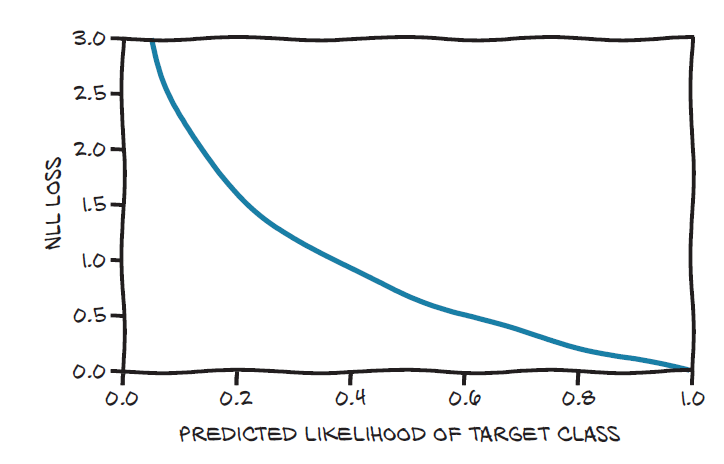

### torch.nn.NLLLoss vs torch.nn.CrossEntropyLoss()

**nn.NLLLoss** does not take probabilities but rather takes a tensor of **log** probabilities as input.

The workaround is to use **nn.LogSoftmax** instead of nn.Softmax, which takes care to make
the calculation numerically stable.
```
model = nn.Sequential(
    nn.Linear(3072, 512),
    nn.Tanh(),
    nn.Linear(512, 2),
    nn.LogSoftmax(dim=1))

loss = nn.NLLLoss()
```

The combination of nn.LogSoftmax and nn.NLLLoss is equivalent to using **nn.CrossEntropyLoss**. So it is quite common to drop the last nn.LogSoftmax layer from the network and use nn.CrossEntropyLoss as a loss.
```
model = nn.Sequential(
    nn.Linear(3072, 1024),
    nn.Tanh(),
    nn.Linear(1024, 512),
    nn.Tanh(),
    nn.Linear(512, 128),
    nn.Tanh(),
    nn.Linear(128, 2))
    
loss_fn = nn.CrossEntropyLoss()
```

**note: nn.CrossEntropyLoss expects integer class labels.**

## Loss Function for Binary Classification

### torch.nn.BCELoss() vs torch.nn.BCEWithLogitsLoss()
This is the Binary Cross Entropy. Specially for binary classification to assess the probablity from sigmoid function.

https://pytorch.org/docs/stable/generated/torch.nn.BCELoss.html

In [ ]:
m = nn.Sigmoid()
loss = nn.BCELoss(reduction='none')
loss2 = nn.BCEWithLogitsLoss(reduction='none')

input = torch.tensor([1.1, 2.2, 0.5, -1.1, -2.2])
target = torch.tensor([1., 1., 0., 0., 0.])
print('input -->', input)
print('target -->', target)
print()

output = loss(m(input), target)
print('output of BCELoss-->', output)
print('output.mean() of BCELoss -->', output.mean())
print()

output = loss2(input, target)
print('output of BCEWithLogitsLoss -->', output)
print('output.mean() of BCEWithLogitsLoss -->', output.mean())
print()

print('-torch.log(m(input):')
print(-torch.log(m(input)))
print()

import torch.nn.functional as F
print('F.binary_cross_entropy -->', F.binary_cross_entropy(m(input), target))

## Get Parameters

In [ ]:
numel_list = [param.numel() for param in model.parameters()]

sum(numel_list), numel_list

In [ ]:
numel_list = [param.numel() for param in model.parameters() if param.requires_grad == True]

sum(numel_list), numel_list

## Check if Iterable and Iterator

* **Dataset** object has \_\_getitem\_\_() and \_\_len\_\_() which enable iteration over the data items
* **Dataloader** object is an Iterable, passing it to iter() returns an iterator which you can iterate trough.

In [9]:
from collections.abc import Iterable, Iterator, Generator

print(isinstance(cifar10, Iterable))
print(isinstance(cifar10, Iterator))
print(isinstance(cifar10, Generator))
print()

print(isinstance(train_loader, Iterable))
print(isinstance(train_loader, Iterator))
print(isinstance(train_loader, Generator))
print()

a = iter(train_loader)
print(isinstance(a , Iterable))
print(isinstance(a , Iterator))
print(isinstance(a , Generator))

False
False
False

True
False
False

True
True
False
